In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from statsmodels.datasets import get_rdataset

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, ShuffleSplit, cross_validate, KFold, GridSearchCV

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import (DecisionTreeClassifier as DTC ,
DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RFR,
RandomForestClassifier as RFC,
GradientBoostingRegressor as GBR,
GradientBoostingClassifier as GBC)
from ISLP.bart import BART

Decision Tree - Lecture
Learned how to go from 2D visualization to tree form. Pretty intuitive and actually good for interpretation. 
You can get really good predictions, sure. But prone to overfitting! 
Less splits = better? for predicting.
Minimum decrease in RSS? No can get screwed by a bad split.
Better yet..Grow a big tree and prune.
Do it by cost complexity. Basically introduce a regularization term for # of terminal nodes in the tree.

How to do the determine the best split? Can calculate thresehold with least sum of squares.

Classification Tree 
Minimize misclassifications instead of RSS.
But if we don't want a bunch of impure nodes, then we use entropy or gini index. These are basically concave curvesthat rewards 0 or 1 purity.
Entropy -sum p log (p)
Gini - sum p(1-p)
We can use cross validation - minimizei cross validation error or RSS to know how much to prune (tree size or complexity)

In [17]:
df = pd.read_csv('result.csv')

active=[i for i in df.columns if "Active_" in i]
bowel=[i for i in df.columns if"Bowel Movements_" in i]
creative=[i for i in df.columns if "Creative_" in i]
lifestyle=[i for i in df.columns if "Lifestyle_" in i]
meds=[i for i in df.columns if "Meds/Supplements_" in i]
energy=[i for i in df.columns if "Energy_" in i]
mood=[i for i in df.columns if "Mood_" in i]
nutrition=[i for i in df.columns if "Nutrition_" in i]
sleep=[i for i in df.columns if "Sleep_" in i]

symptom=[i for i in df.columns if "Symptom_" in i]
weather=[i for i in df.columns if "Weather_" in i]
sleep_metrics=['deep_sleep','efficiency_x','latency','rem_sleep','restfulness','timing','total_sleep']  #what is efficiency y?
hrv=['average_breath','average_heart_rate','average_hrv','lowest_heart_rate']
sleep_times=['awake_time','deep_sleep_duration','latency_duration','light_sleep_duration','rem_sleep_duration','restless_periods','time_in_bed','total_sleep_duration']
readiness=[i for i in df.columns if "readiness_" in i]

sleep=['Sleep_Blue','Sleep_Drink water before bed','Sleep_Early Bedtime','Sleep_Fan on','Sleep_Individual blanket','Sleep_Late Bedtime','Sleep_Screentime 1h from bedtime','day_of_week','is_weekend']
y_var='deep_sleep'
x_var=sleep+active+lifestyle+nutrition
X=df[x_var]
y=np.array(df[y_var]).reshape(-1,1)
print(X.shape)
print(y.shape)

(164, 69)
(164, 1)


To get a learning curve, test set, you have some do some bs grid search thing just to pass the model. so annoying.
* For the training curve, make 1 tree model for every parametr value (max_leaf_nodes), fit model on X training and y training, then predict on itself to get accuracy
* For the cv, make 1 tree model for every parametr value, find cv scores, 
* For the test curve, need to actually to the model. 

Can add a 1 tree size to the chart, but its basically the 46% or so (can't be done in for loop)

Bagging - Lecture
Bagging is just a general term for reducing variance, averaging predictions.
Bagging = Bootstrap aggregation. Why bootstrap? More observations = reduced variance. But why is this allowed?
According to chat gpt we do this in decision trees (high variance models), which is true. Whereas regression models are typically lower variance. 
We;re averaging many predictions!
Typically # of trees doesn't overfit (test error doesn't go up). Very interesting. averageing overfit models still creates a smooth, stable ensemble. Also reduced variance.

In OOB estimation, roughly 2/3 is used in a bagged tree. 1/3 observations are not used to fit a bagged tree, used as OOB. So we we naturally have validation. Better computationally!!
"The resulting OOB error is a valid
estimate of the test error for the bagged model, since the response for each
observation is predicted using only the trees that were not fit using that
observation."

And random forest we are also growing trees independently on random samples of the observations. However, eatcch split on each triee is performed using random subset of features, decorrelating the trees and getting deper exploration of model space relative to bagging.
Also we see random forest decreases to stable faster than bagged trees. Random forest Decorrelates the trees! Due to random sample of predictors. 
Random forest, parameter subset, m ~= sqrt(p)

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably m

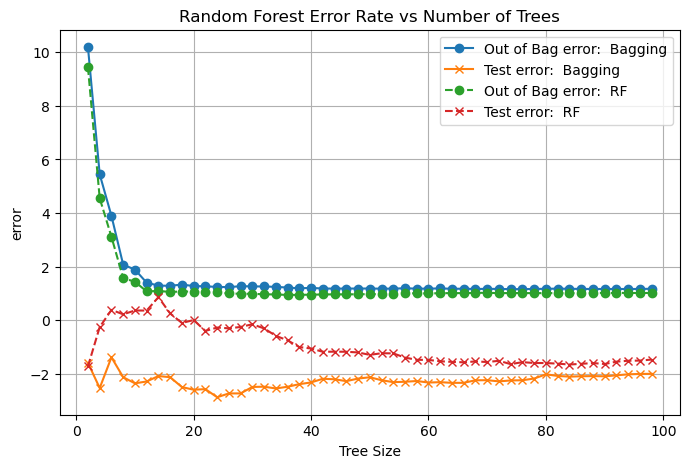

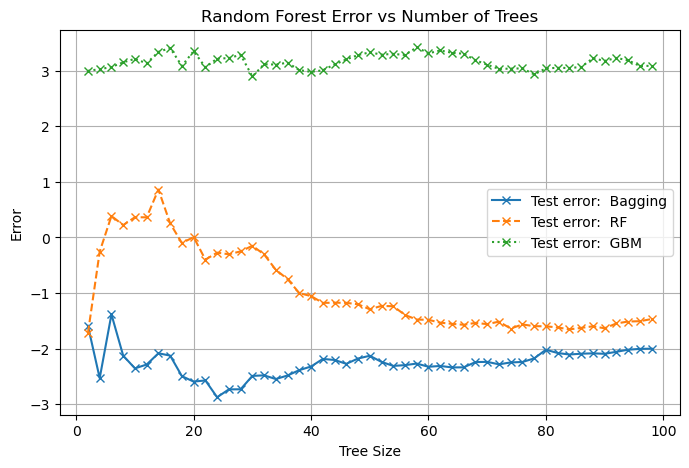

In [18]:

(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

num_trees = list(range(2,100,2))
error_oob_bag=[]
error_training_bag=[]
error_test_bag=[]

error_oob_rf=[]
error_training_rf=[]
error_test_rf=[]

error_oob_gbm=[]
error_test_gbm=[]

for i in num_trees:
    bagg=RFR(n_estimators=i,random_state=0,max_features=None,oob_score=True, )
    bagg.fit(X_train,y_train)
    oob_error=1-bagg.oob_score_
    error_oob_bag.append(oob_error)
    train_error=np.mean(y_train-bagg.predict(X_train))
    error_training_bag.append(train_error)
    test_error=np.mean(y_test-bagg.predict(X_test))
    error_test_bag.append(test_error)
for i in num_trees:
    rfg=RFR(n_estimators=i,random_state=0,max_features='sqrt',oob_score=True, )
    rfg.fit(X_train,y_train)
    oob_error=1-rfg.oob_score_
    error_oob_rf.append(oob_error)
    test_error=np.mean(y_test-rfg.predict(X_test))
    error_test_rf.append(test_error)

for i in num_trees:
    gbm = GBR(n_estimators=i, learning_rate=0.1, random_state=42, subsample=0.8)
    gbm.fit(X_train,y_train)
    oob_error=1-gbm.oob_score_
    error_oob_gbm.append(oob_error)
    test_error=np.mean(y_test-gbm.predict(X_test))
    error_test_gbm.append(1-test_error)

plt.figure(figsize=(8, 5))
plt.plot(num_trees, error_oob_bag, marker='o', linestyle='-', label="Out of Bag error:  Bagging")
plt.plot(num_trees, error_test_bag, marker='x', linestyle='-', label="Test error:  Bagging")
plt.plot(num_trees, error_oob_rf, marker='o', linestyle='--', label="Out of Bag error:  RF")
plt.plot(num_trees, error_test_rf, marker='x', linestyle='--', label="Test error:  RF")
plt.xlabel("Tree Size")
plt.ylabel("error")
plt.title("Random Forest Error Rate vs Number of Trees")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(num_trees, error_test_bag, marker='x', linestyle='-', label="Test error:  Bagging")
plt.plot(num_trees, error_test_rf, marker='x', linestyle='--', label="Test error:  RF")
plt.plot(num_trees, error_test_gbm, marker='x', linestyle=':', label="Test error:  GBM")
plt.xlabel("Tree Size")
plt.ylabel("Error")
plt.title("Random Forest Error vs Number of Trees")
plt.legend()
plt.grid()
plt.show()



How its useful for variable importance:
Its an overall summary of importance each predictor, using RSS (for regression trees)
Or Gini Index (for classification trees)

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\jhuang\AppData\Local\Temp\ipykernel_28912\683280173.py:13: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


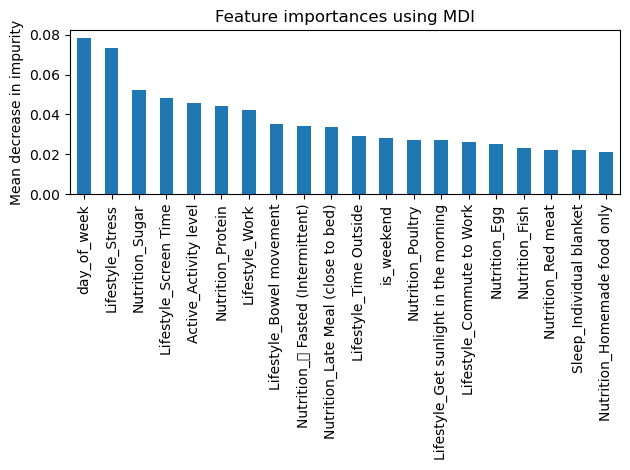

In [ ]:
rfg=RFR(n_estimators=50,random_state=0,max_features='sqrt',oob_score=True, )
rfg.fit(X_train,y_train)

feature_names=X.columns
importances = rfg.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


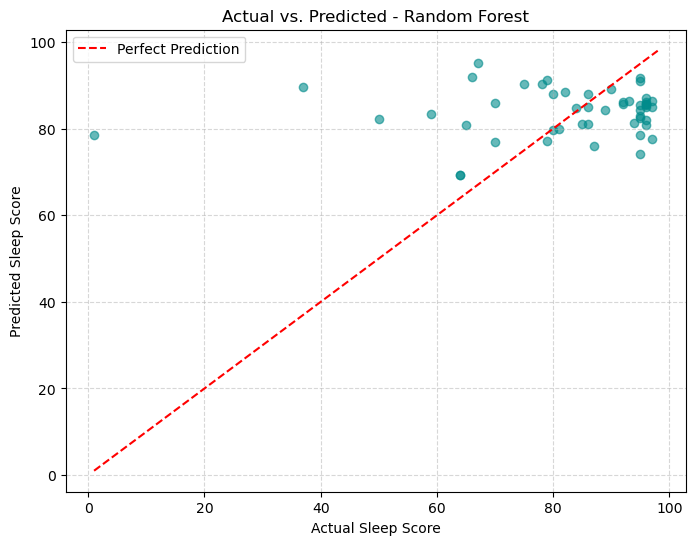

R²: -0.021
RMSE: 18.178
MAE: 12.602


c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
y_pred = rfg.predict(X_test)

# Actual vs. Predicted Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="darkcyan")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Sleep Score")
plt.ylabel("Predicted Sleep Score")
plt.title("Actual vs. Predicted - Random Forest")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Performance metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9193 (\N{BLACK RIGHT-POINTING DOUBLE TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


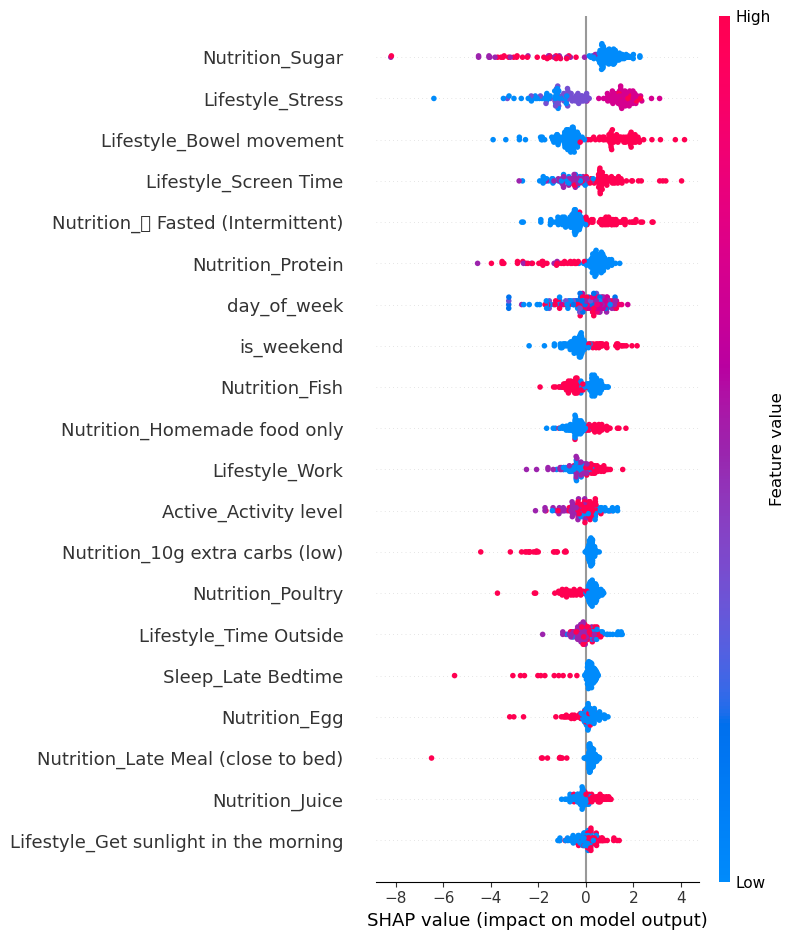

In [20]:
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X)  # SHAP values for each row (same shape as X)
shap.summary_plot(shap_values, X)

Lecture - Boosting
Start with Adaboost

RF:
1. Trees
2. equal says
3. trees are independent.

Adaboost:
1. Stumps
2. some stumps worth more
3. stump takes into accout previous stumps.

Determine first stump. Is the variable that has the lowest gini index.
Then determine how much say it will have in the final classification.
Based on Total error rate of split, find amount of say. Then use amount of say to weight sample.
Can use weighted gini function and use it with sample weights. ortherwise just sample weights as a probability and make a new dataset that reflects those weights.

For classification. total amount of say for all the stumps for 1 class, that determines class. 

Gradient Boost.
Usually predetermined. Max leaves = 4 in this case. Predict the residuals.

In regression settings:
Start with average value.
Loop: 
    Calculate residuals.
    Predict these residuals with a tree. For leaves with multiple values, replace with average.
    Now we predict values = avg value + alpha*(tree). Learning rate acts as the 'gradient.' Small steps in right direction. lower variance.
Go until residuals stop or hit max number of trees


1. Start with leaf.
2. Build tree, based on previous 

| Syntax      | Description |
| ----------- | ----------- |
| Header      | Title       |
| Paragraph   | Text        |


c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


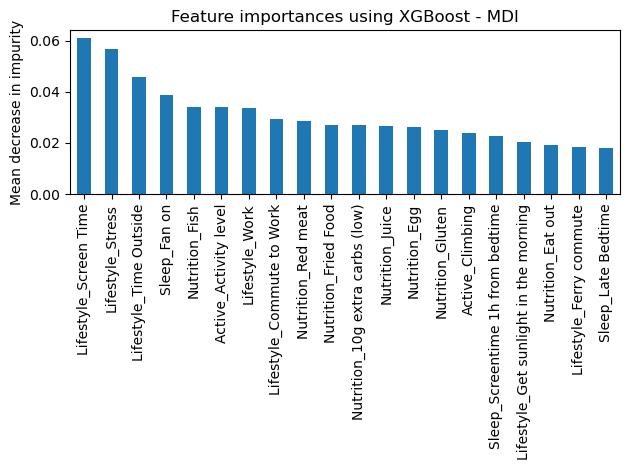

In [17]:
y_var='score'
x_var=sleep+active+lifestyle+nutrition
X=df[x_var]
y=np.array(df[y_var]).reshape(-1,1)

(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

gbm = GBC(n_estimators=50, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)
importances = gbm.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using XGBoost - MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


NameError: name 'rf_model' is not defined